In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("/home/maddie/SmartIoT-2025/GANs models/")
from ad_utils import *

cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("hvcm/RFQ.npy", allow_pickle=True)
label = np.load("hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)
X_train_faulty, X_test_faulty, y_train_faulty, y_test_faulty = train_test_split(faulty_data, faulty_label, test_size=0.2, random_state=42, shuffle=True)

NVIDIA A30
(872, 4500, 14) (872,)



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 138
Faulty samples: 37
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 110
Fold 1 - Train faulty: 30
Fold 1 - Test: 35 (28 normal, 7 faulty)
Processing data through feature extraction...
Processing 30 samples with multi-channel approach...
Processing 35 samples with multi-channel approach...
Processing 110 samples with multi-channel approach...
Training baseline autoencoder (without GAN)...
Fold 1 - Using original normal data only
Processing 110 samples with multi-channel approach...
Training GAN-augmented autoencoder...

Fold 1 Results Comparison:
--------------------------------------------------------------------------------
Method             | Metric   | Baseline   | GAN-Aug    | Improvement 
--------------------------------------------------------------------------------
F1_Threshold       | accuracy | 0.9143     | 0.9143     | +0.0000     
F

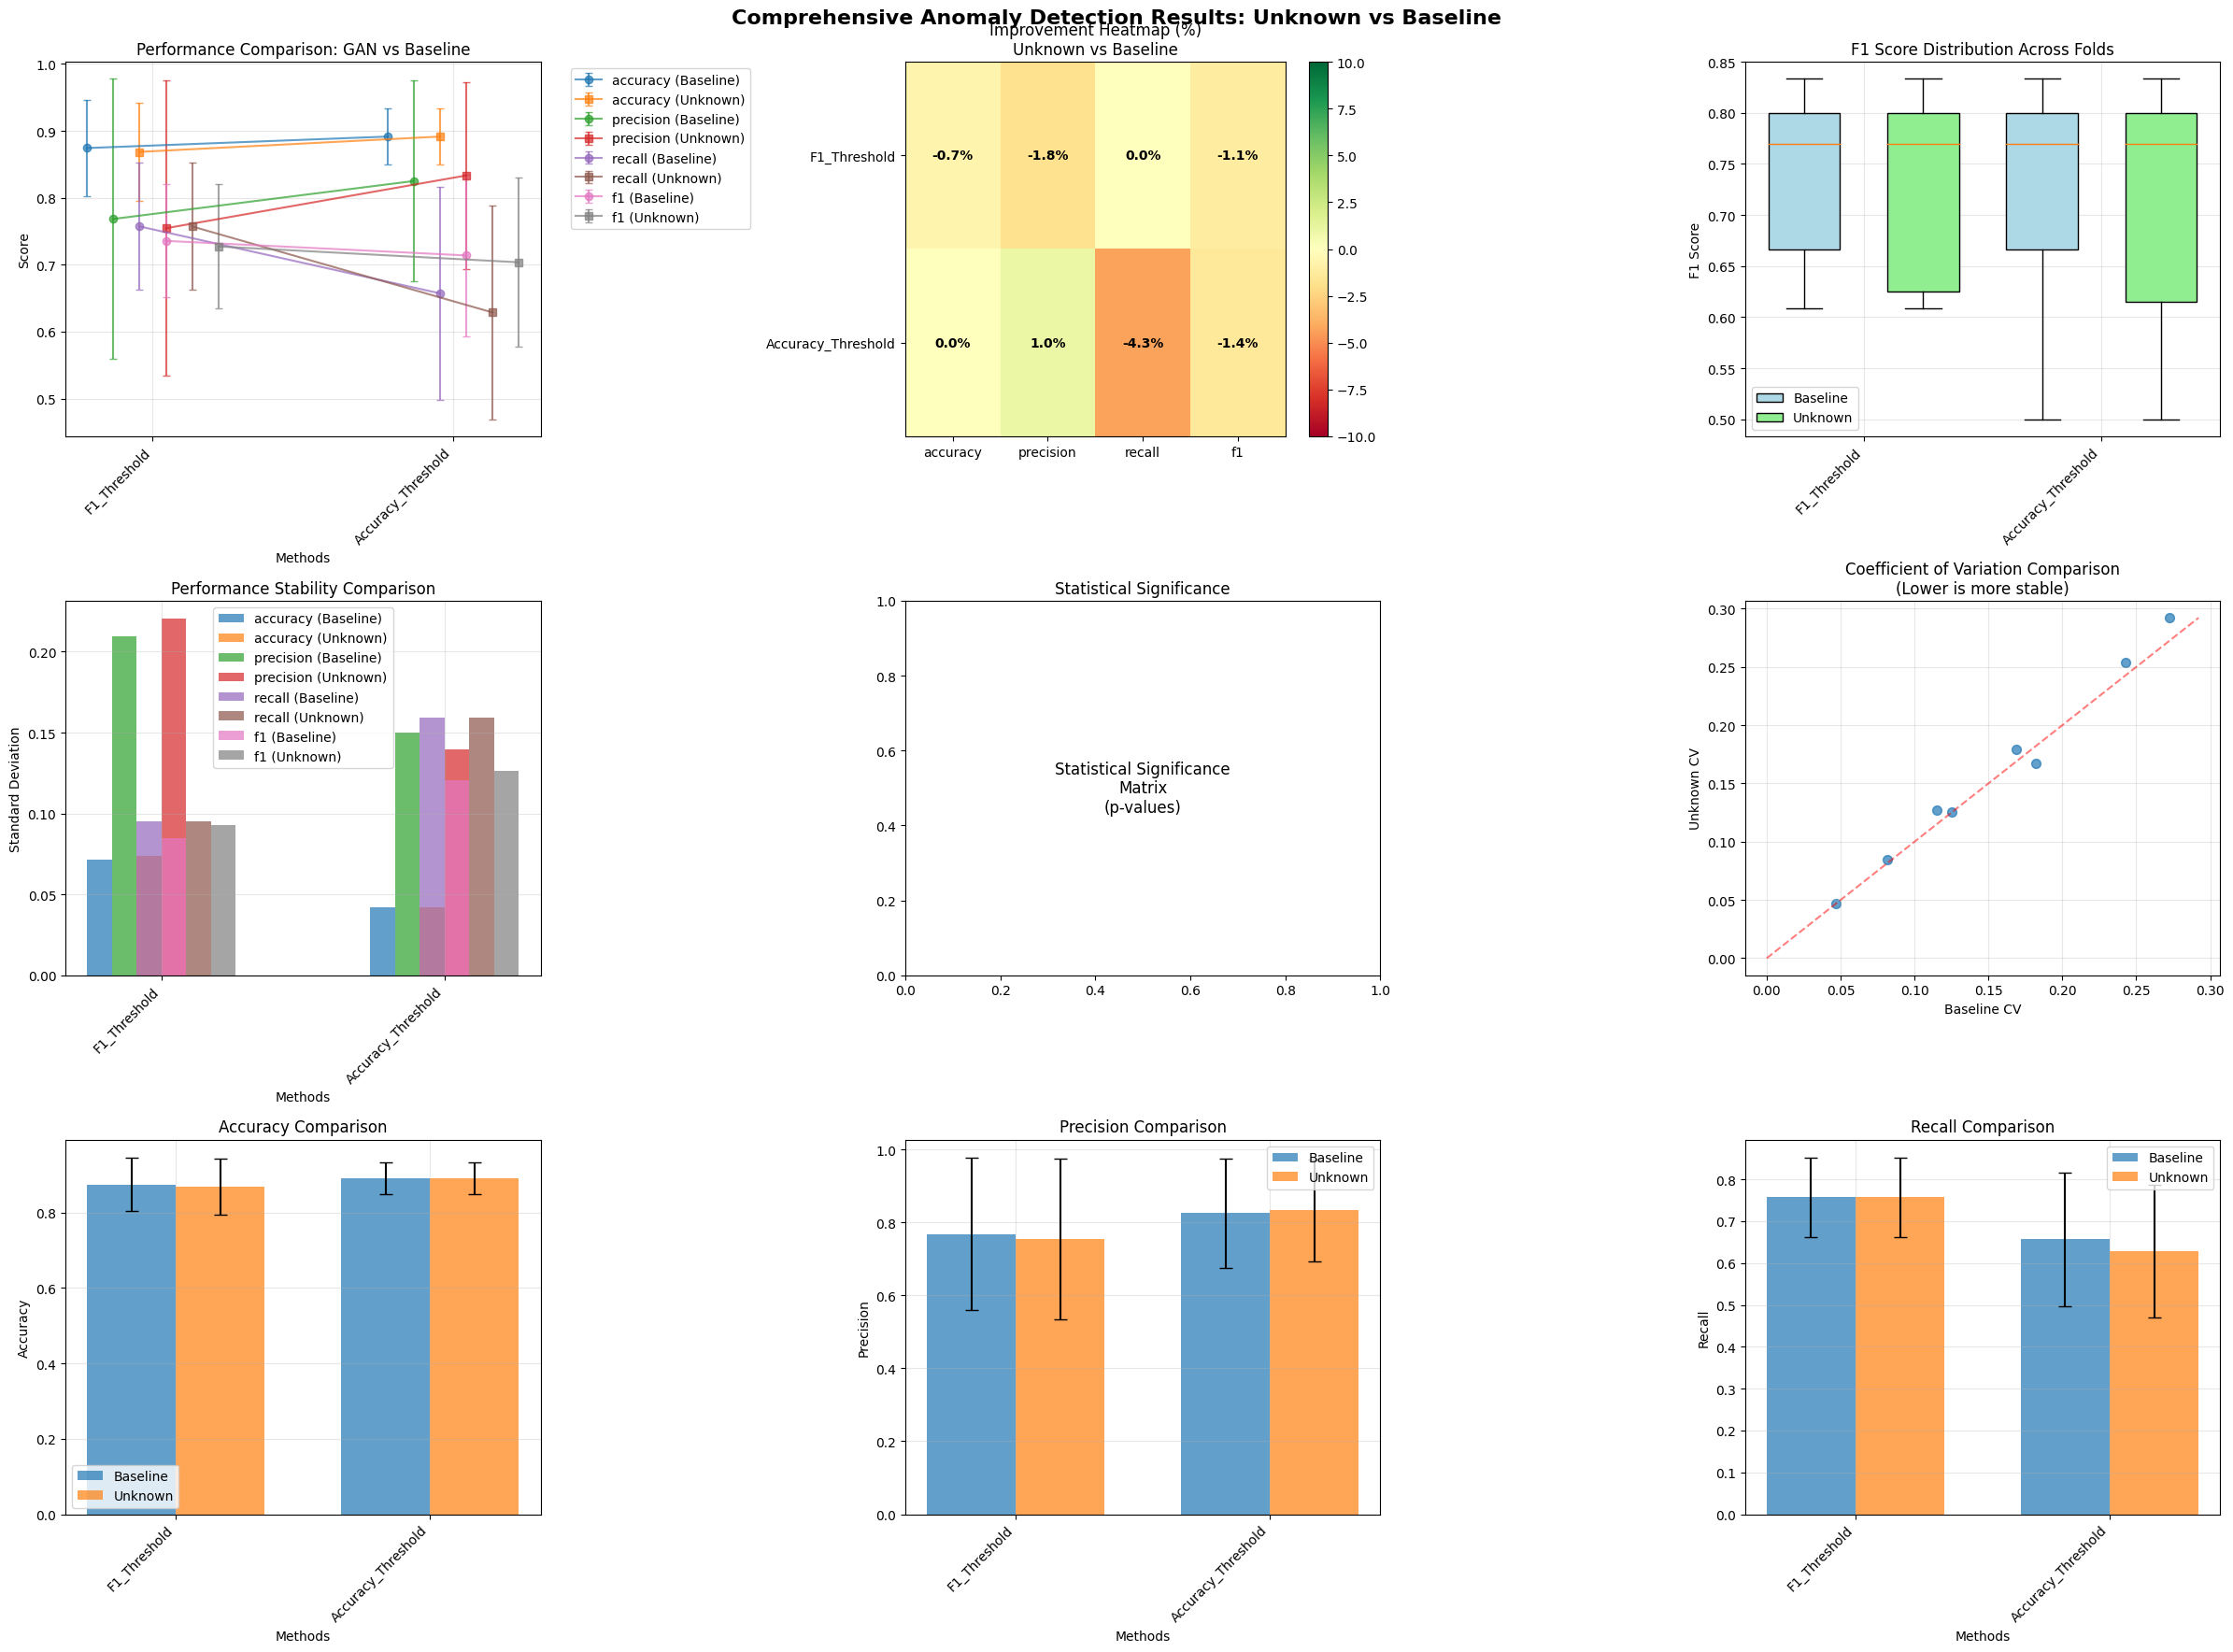


ENHANCED ANOMALY DETECTION RECOMMENDATIONS (Unknown)

🏆 BEST METHODS WITH Unknown:
   • Best F1 Score: F1_Threshold (0.7273 ± 0.0925)
   • Most Stable: F1_Threshold (CV = 0.1272)

📈 Unknown EFFECTIVENESS:
   • F1_Threshold: 0% metrics improved, 0% significantly
   • Accuracy_Threshold: 25% metrics improved, 0% significantly

🎯 Unknown OVERALL EFFECTIVENESS: Not Effective
   • 0/8 comparisons show significant improvement
   • Success Rate: 0.0%

📊 METHOD-SPECIFIC INSIGHTS:
   • F1_Threshold          : No Significant Benefit
   • Accuracy_Threshold    : No Significant Benefit

🎯 FINAL RECOMMENDATIONS:
   ❌ Unknown data augmentation shows LIMITED benefit
   • Consider baseline methods or alternative GAN architectures
   • Current success rate: 0.0%

💡 DEPLOYMENT STRATEGY:
   • Stick with baseline methods for now
   • Investigate alternative data augmentation strategies
   • Consider ensemble methods combining multiple approaches



({'F1_Threshold': {'accuracy': {'mean': 0.8685714285714287,
    'std': 0.07362342129557212,
    'min': 0.7428571428571429,
    'max': 0.9428571428571428,
    'median': 0.9142857142857143,
    'values': [0.9142857142857143,
     0.8285714285714286,
     0.9428571428571428,
     0.9142857142857143,
     0.7428571428571429]},
   'precision': {'mean': 0.7544444444444445,
    'std': 0.2204484766656316,
    'min': 0.4666666666666667,
    'max': 1.0,
    'median': 0.75,
    'values': [0.75, 0.5555555555555556, 1.0, 1.0, 0.4666666666666667]},
   'recall': {'mean': 0.7571428571428571,
    'std': 0.09489521611133157,
    'min': 0.625,
    'max': 0.875,
    'median': 0.7142857142857143,
    'values': [0.8571428571428571,
     0.7142857142857143,
     0.7142857142857143,
     0.625,
     0.875]},
   'f1': {'mean': 0.7272519509476031,
    'std': 0.09254060402413204,
    'min': 0.608695652173913,
    'max': 0.8333333333333333,
    'median': 0.7692307692307693,
    'values': [0.7999999999999999,
    

In [2]:
run_comprehensive_cross_validation_experiment(normal_data=X_test_normal, faulty_data=X_test_faulty, device=device, batch_size=32)